In [1]:
import pickle
import os
import sys

import matplotlib.pyplot as plt
import numpy as np



In [24]:

def load_latents(path):
    # takes names in path 
    names = os.listdir(path)
    names.sort()
    # print(len(names))
    latents = []
    for pkl_name in names:
        with open(path + "/" + pkl_name, 'rb') as f:
            data = pickle.load(f)
            latents.append(data)
    return latents

# visualizations

In [55]:
changes = []
for i in range(len(latents)-1):
    changes.append(latents[i] - latents[0])
    

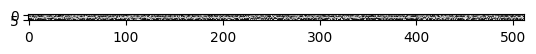

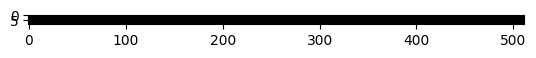

In [56]:
# changes[100]
# plot this as image 
import matplotlib.pyplot as plt
import numpy as np

# plt.imshow(changes[100][0], cmap='gray')
#make large image
# plt.figure(figsize=(20,80))


plt.imshow(changes[100][0][:6], cmap='gray') # first 6 are changed
plt.show()
plt.imshow(changes[100][0][6:], cmap='gray') # unchanged
plt.show()

In [57]:
sum = 0
for i in range(len(changes)):
    sum+=changes[i][0][6:].sum()
print(sum)

0.0


In [58]:
cropped_changes = []
for i in range(len(changes)):
    cropped_changes.append(changes[i][0][:6].flatten()) #(6,512)


In [59]:
def pca(data):
    cropped_changes = np.array(data)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(cropped_changes)
    return components

In [60]:
    # visualize using TSNE
def visualize_tsne(cropped_changes):
        data = np.array(cropped_changes)
        from sklearn.manifold import TSNE
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(data)

        plt.scatter(tsne_results[:,0], tsne_results[:,1])
        plt.show()
        return tsne_results

In [61]:
def create_animation(results,anim_name="animation.gif"):
    # create animation of moving point
    import matplotlib.animation as animation
    from matplotlib.animation import FuncAnimation


    fig, ax = plt.subplots()
    xdata, ydata = [], []
    ln, = plt.plot([], [], 'ro')

    def init():
        # ax.set_xlim(-100, 100)
        # ax.set_ylim(-100, 100)
        # pick limits based on data
        # max_x = max(results[:,0])
        # min_x = min(results[:,0])
        # max_y = max(results[:,1])
        # min_y = min(results[:,1])
        max_x,min_x,max_y,min_y = max(results[:,0]),min(results[:,0]),max(results[:,1]),min(results[:,1])
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)
        
        return ln,

    def update(frame):
        xdata.append(frame[0])
        ydata.append(frame[1])
        ln.set_data(xdata, ydata)
        return ln,

    ani = FuncAnimation(fig, update, frames=results, init_func=init, blit=True) # frames=results
    # plt.show()

    # ani.save('animation.gif', writer='imagemagick', fps=30)
    ani.save(anim_name, writer='imagemagick', fps=30)



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 149 samples in 0.000s...
[t-SNE] Computed neighbors for 149 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 149 / 149
[t-SNE] Mean sigma: 0.533188
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.383690
[t-SNE] KL divergence after 300 iterations: 0.084684


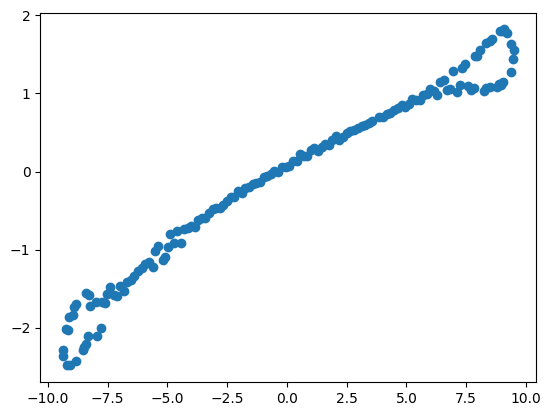

MovieWriter imagemagick unavailable; using Pillow instead.


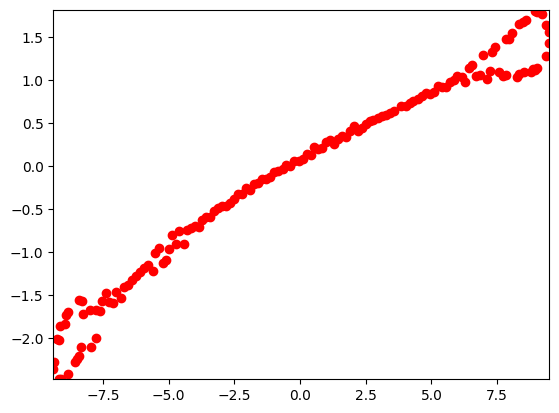

In [62]:
results = visualize_tsne(cropped_changes)
create_animation(results,anim_name="tsne_results.gif")


MovieWriter imagemagick unavailable; using Pillow instead.


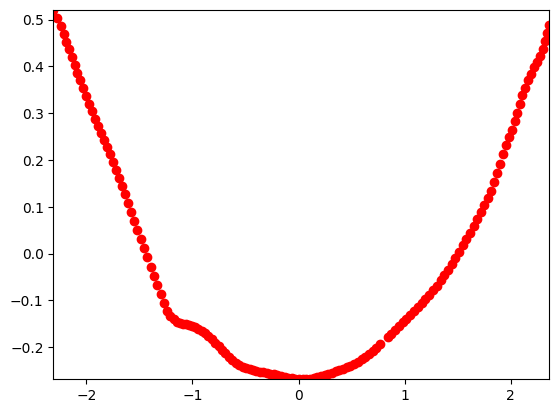

In [63]:
# results = visualize_tsne(cropped_changes)
data = pca(cropped_changes)
create_animation(data,anim_name="pca.gif")


In [68]:
l1 = latents[0][0][:6] #(6, 512)
l_50 = latents[50][0][:6]
l_100 = latents[100][0][:6]

In [71]:
512/8,6*8

(64.0, 48)

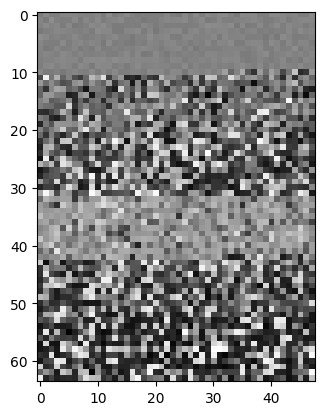

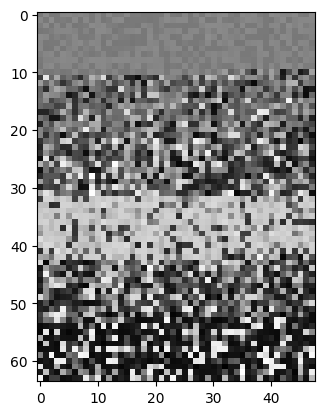

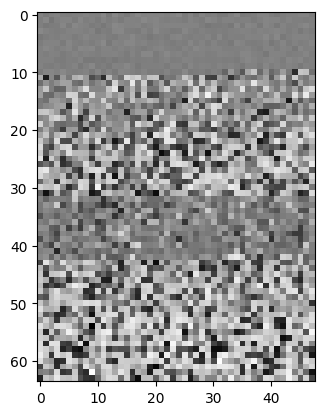

In [72]:
l1_50 = l_50 - l1
l1_100 = l_100 - l1
l50_100 = l_100 - l_50

for l in (l1_50, l1_100, l50_100):
    plt.imshow(l.reshape(64,48), cmap='gray')
    plt.show()


# push it through SG

In [27]:
# path = "/media/Ext_4T_SSD/ASHOK/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents/edited"
path = "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents/edited"

frames = ["000",'001','005']
latents_dict = {}
for frame in frames:
    latents_dict[frame] = load_latents(path + "/" + frame)

In [28]:
changes_dict = {}
for frame in frames:
    changes_dict[frame] = latents_dict[frame][0] - latents_dict[frame][-1]

In [47]:
draggan_path ="/home/bean/DragVideo/DragGAN/"
os.chdir(draggan_path)    
    
def SG_infer(w_load,sg_weights_path,is_path = True):
    temp_file = "./__temp_pkl.pkl"
    if is_path is False:
        w_load = pickle.load(open(w_load,'rb'))
    from _visualizer_auto import DragVideo
    import torch
    if is_path:
        w_load = pickle.load(open(w_load,'rb'))

    stylegan2_wieghts_path = sg_weights_path
    
    edited_latents_dir = './__temp'
    w_load = torch.tensor(w_load)
    # w_load = torch.load(w_load_path)
    drag_video = DragVideo(w_load=w_load,
                        stylegan2_wieghts_path=stylegan2_wieghts_path,
                        edited_latents_dir=edited_latents_dir,
                        verbose=False)

    feat = drag_video.run(N_STEPS=1,points=dict())
    # remove ./__temp
    from shutil import rmtree
    rmtree(edited_latents_dir)
    # remove temp file if exists
    # if os.path.exists(temp_file):
    #     os.remove(temp_file)
    return drag_video.global_state['images']['image_raw'].copy()

In [7]:

w_path = "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents/edited/018/0.pkl"
stylegan2_wieghts_path = "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg/tuned_SG/stylegan3_EZXZEVVUYSPX.pkl"
tuned_image = SG_infer(w_path,stylegan2_wieghts_path)
# empty catched data in gpu
import torch
torch.cuda.empty_cache()

intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg/tuned_SG/stylegan3_EZXZEVVUYSPX.pkl"... Done.
()
{'z_dim': 512, 'w_dim': 512, 'channel_base': 65536, 'channel_max': 1024, 'mapping_kwargs': {}, 'conv_kernel': 1, 'filter_size': 6, 'magnitude_ema_beta': 0.9988915792636801, 'output_scale': 0.25, 'c_dim': 0, 'img_resolution': 1024, 'img_channels': 3, 'use_radial_filters': True}


100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


In [43]:
b = "/home/bean/DragVideo/Data_store/OLD/model_weights/stylegan3_3rdtime_weights/stylegan3-r-ffhq-1024_module.pkl"
untuned_image = SG_infer(w_path,b)
import torch
torch.cuda.empty_cache()

intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/OLD/model_weights/stylegan3_3rdtime_weights/stylegan3-r-ffhq-1024_module.pkl"... Done.
()
{'z_dim': 512, 'w_dim': 512, 'channel_base': 65536, 'channel_max': 1024, 'mapping_kwargs': {}, 'conv_kernel': 1, 'filter_size': 6, 'magnitude_ema_beta': 0.9988915792636801, 'output_scale': 0.25, 'c_dim': 0, 'img_resolution': 1024, 'img_channels': 3, 'use_radial_filters': True}


100%|██████████| 1/1 [00:00<00:00,  6.32it/s]


In [32]:
w1 = latents_dict['000'][0]
dw1 = changes_dict['000']
dw2 = changes_dict['001']


In [85]:
w_mirr = torch.load('/home/bean/DragVideo/Data_store/experiments/_SAVE_mirrAR_200_frames_2/latents/barcelona/PTI/000/0.pt')
w_mirr = np.array(w_mirr.detach().cpu())

In [102]:
w_mirr = torch.load('/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents/barcelona/PTI/114/0.pt')
w_mirr = np.array(w_mirr.detach().cpu())

In [109]:
# original_path = "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents/barcelona/PTI/000/0.pt"
# edited_path = "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents2/barcelona/PTI/000/0.pt"
def change_latents(name,dw1):
    path =f"/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents/barcelona/PTI/{name}/0.pt"
    w_mirr = torch.load(path)
    w_mirr = np.array(w_mirr.detach().cpu())
    w_mirr = w_mirr -3*dw1
    w_mirr = torch.tensor(w_mirr)
    # save_path = f"/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents2/barcelona/PTI/{name}/0.pt"
    save_path =f'/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents_2/barcelona/PTI/{name}/0.pt'
    torch.save(w_mirr,save_path)
    

In [110]:
for i in range(100):
    change_latents(str(i).zfill(3),dw1)

In [33]:
w1.shape

(1, 16, 512)

In [105]:
# inp = w1 - 2*dw1
inp = w_mirr - 3*dw1

# store w1 in temp file
temp_file = "./__temp_pkl.pkl"
with open(temp_file, 'wb') as f:
    pickle.dump(inp, f)

intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg/tuned_SG/stylegan3_EZXZEVVUYSPX.pkl"... Done.
()
{'z_dim': 512, 'w_dim': 512, 'channel_base': 65536, 'channel_max': 1024, 'mapping_kwargs': {}, 'conv_kernel': 1, 'filter_size': 6, 'magnitude_ema_beta': 0.9988915792636801, 'output_scale': 0.25, 'c_dim': 0, 'img_resolution': 1024, 'img_channels': 3, 'use_radial_filters': True}


100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


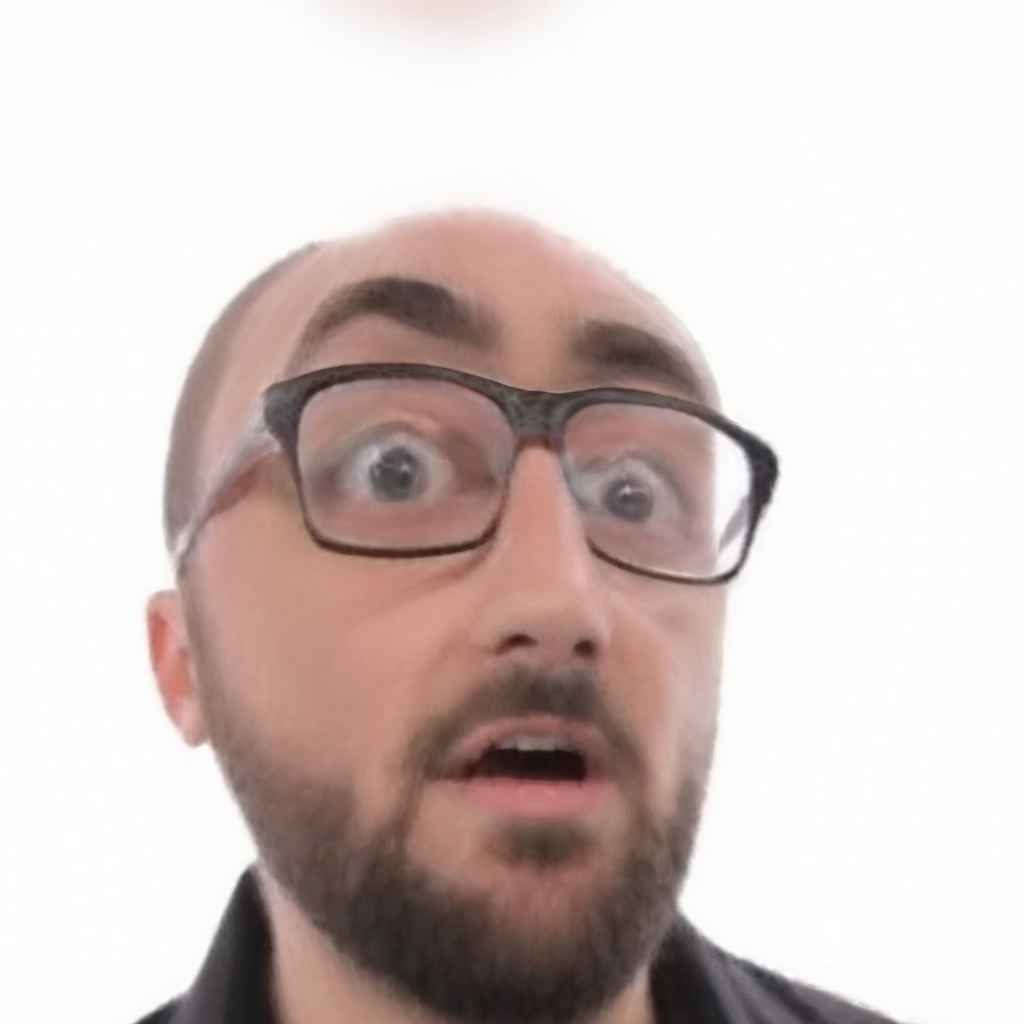

In [106]:
img0 = SG_infer("./__temp_pkl.pkl",stylegan2_wieghts_path,is_path=True)
img0

path = "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy/latents_2/barcelona/PTI/014/0.pt"

intiating global state....
calling init_images......
Loading "/home/bean/DragVideo/Data_store/OLD/model_weights/stylegan3_3rdtime_weights/stylegan3-r-ffhq-1024_module.pkl"... Done.
()
{'z_dim': 512, 'w_dim': 512, 'channel_base': 65536, 'channel_max': 1024, 'mapping_kwargs': {}, 'conv_kernel': 1, 'filter_size': 6, 'magnitude_ema_beta': 0.9988915792636801, 'output_scale': 0.25, 'c_dim': 0, 'img_resolution': 1024, 'img_channels': 3, 'use_radial_filters': True}


100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


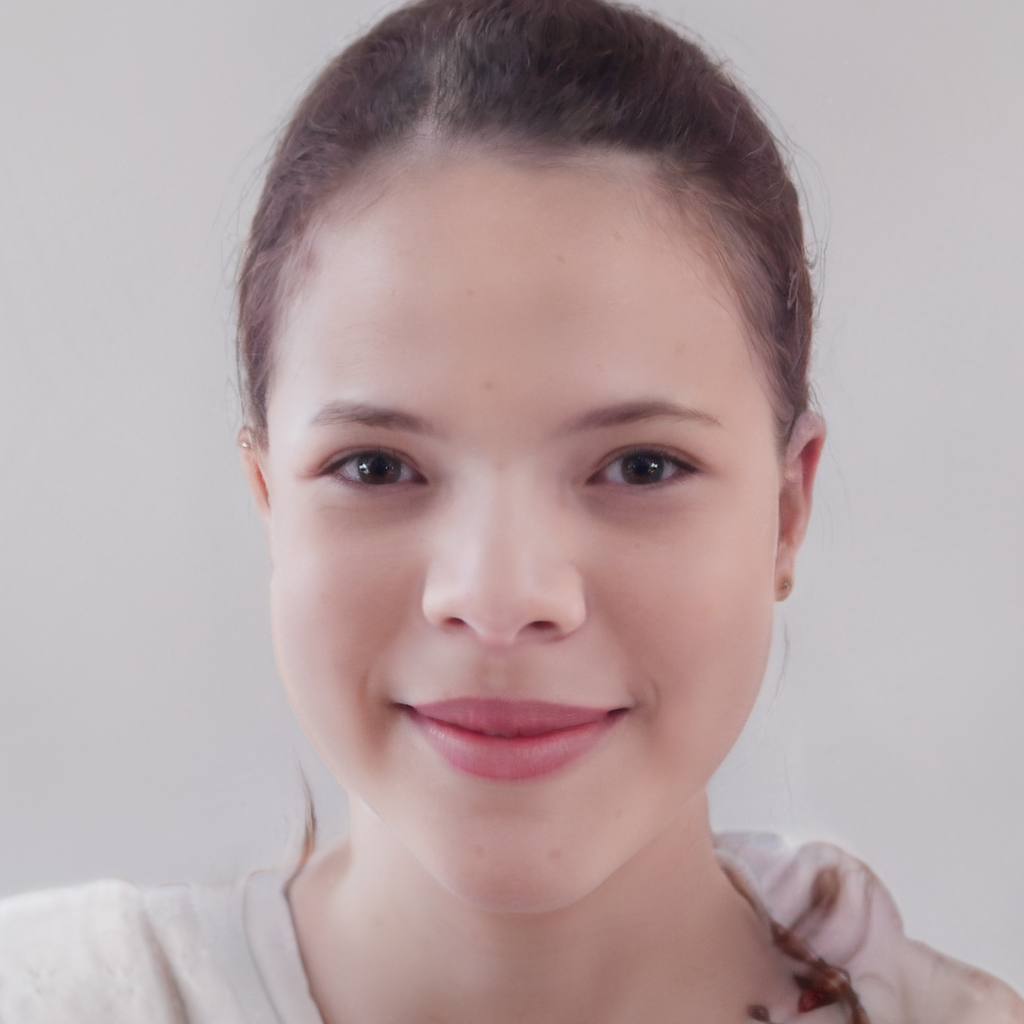

In [96]:
img0 = SG_infer("./__temp_pkl.pkl",b,is_path=True)
img0

In [63]:
changes

NameError: name 'changes' is not defined

In [15]:
import pickle
def load_G(f):
    with open(f, "rb") as f:
        data = pickle.load(f)
    key = "G_ema"
    _device = "cuda"
    from training.networks_stylegan3 import Generator
    net = Generator(*data[key].init_args, **data[key].init_kwargs)
    net.load_state_dict(data[key].state_dict())
    net.to(_device)
    return net

In [25]:

def run_SG(
                      G,
                      ws,
        points          = [],
        targets         = [],
        mask            = None,
        lambda_mask     = 10,
        reg             = 0,
        feature_idx     = 5,
        r1              = 3,
        r2              = 12,
        random_seed     = 0,
        noise_mode      = 'const',
        trunc_psi       = 0.7,
        force_fp32      = False,
        layer_name      = None,
        sel_channels    = 3,
        base_channel    = 0,
        img_scale_db    = 0,
        img_normalize   = False,
        untransform     = False,
        is_drag         = False,
        reset           = False,
        to_pil          = False,
        _device = "cuda",
        **kwargs
    ):
        # return

        # G = self.G
        # ws = self.w
        if ws.dim() == 2:
            ws = ws.unsqueeze(1).repeat(1,6,1)
        # ws = torch.cat([ws[:,:6,:], self.w0[:,6:,:]], dim=1)
        
        
        # if hasattr(self, 'points'):
        #     if len(points) != len(self.points):
        #         reset = True
        # if reset:
        #     self.feat_refs = None
        #     self.points0_pt = None
        # self.points = points

        # Run synthesis network.
        label = torch.zeros([1, G.c_dim], device=_device)
        img, feat = G(ws, label,
                      truncation_psi=trunc_psi,
                      noise_mode=noise_mode,
                      input_is_w=True,
                      return_feature=True)

        h, w = G.img_resolution, G.img_resolution
        # return img
    
        # Scale and convert to uint8.
        img = img[0]
        if img_normalize:
            img = img / img.norm(float('inf'), dim=[1,2], keepdim=True).clip(1e-8, 1e8)
        img = img * (10 ** (img_scale_db / 20))
        img = (img * 127.5 + 128).clamp(0, 255).to(torch.uint8).permute(1, 2, 0)
        if to_pil:
            from PIL import Image
            img = img.cpu().numpy()
            img = Image.fromarray(img)
        
        return img.detach().cpu().numpy()

        
            

In [26]:
# ws random of shape (1,16,512)
import torch
_device = "cuda"
# ws = torch.randn(1,16,512).to(_device)
ws_path = "/home/bean/DragVideo/Data_store/experiments/_SAVE_vsauce_ffmpeg_untuned_sg_copy_latent_edit/latents/barcelona/PTI/074/0.pt"
ws = torch.load(ws_path).to(_device)
G = load_G(f)

img = run_SG(G,ws)


In [29]:
img.shape

torch.Size([1024, 1024, 3])

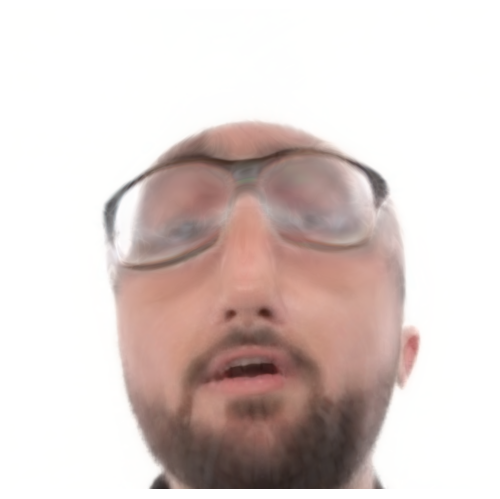

In [33]:
import matplotlib.pyplot as plt
plt.imshow(img.detach().cpu().numpy())#.transpose(1,2,0))
plt.axis('off')
plt.show()

In [23]:
img.max(),img.min()

(tensor(1.0371, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-0.8496, device='cuda:0', grad_fn=<MinBackward1>))